In [ ]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/Google colab Save/kaggle/0.doc_for_me

Mounted at /content/drive
/content/drive/My Drive/Google colab Save/kaggle/0.doc_for_me


In [ ]:
data_path = 'data/train_sample.csv'
df = pd.read_csv(data_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300561 entries, 0 to 2300560
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 140.4+ MB


# Base Line Model
- assign
- label encoder
- lightGBM

## assign : 날짜 정보 
- when convert the col having datetime but not having its dtype as datetime
  - convert to datetime object
  - ks = ks.assign(outcome=(ks['state'] == 'successful').astype(int))
          ks = ks.assign(hour=ks.launched.dt.hour,
                          day=ks.launched.dt.day,
                          month=ks.launched.dt.month,
                          year=ks.launched.dt.year)

In [ ]:
df['click_time'] = pd.to_datetime(df['click_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300561 entries, 0 to 2300560
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   ip               int64         
 1   app              int64         
 2   device           int64         
 3   os               int64         
 4   channel          int64         
 5   click_time       datetime64[ns]
 6   attributed_time  object        
 7   is_attributed    int64         
 8   day              int64         
 9   hour             int64         
 10  minute           int64         
 11  second           int64         
 12  ip_labels        int64         
 13  app_labels       int64         
 14  device_labels    int64         
 15  os_labels        int64         
 16  channel_labels   int64         
dtypes: datetime64[ns](1), int64(15), object(1)
memory usage: 298.4+ MB


In [ ]:
df = df.assign(day = df['click_time'].dt.day.astype('int'),
              hour = df['click_time'].dt.hour.astype('int'),
              minute = df['click_time'].dt.minute.astype('int'),
              second = df['click_time'].dt.second.astype('int'))
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,27226,3,1,13,120
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,110007,35,1,13,10
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,1047,6,1,13,157
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,76270,3,1,13,120
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,57862,3,1,13,120


## LabelEncoder : 오브젝트 > 카테고리 숫자
- convert categorical variable into numeric
- from sklearn.preprocessing import LabelEncoder
    - encoder = LabelEncoder()

In [ ]:
from sklearn.preprocessing import LabelEncoder

tgt_col = ['ip','app','device','os','channel']
encoder = LabelEncoder()

for col in tgt_col:
  new_name = f'{col}_labels'
  df[new_name] = encoder.fit_transform(df[col])

df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,27226,3,1,13,120
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,110007,35,1,13,10
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,1047,6,1,13,157
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,76270,3,1,13,120
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,57862,3,1,13,120


## lightGBM 
- tree-based model that typically provides the best performance, even compare to XGBoost

In [ ]:
feature_cols = ['day', 'hour', 'minute', 'second', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

valid_fraction = 0.1
df_srt = df.sort_values('click_time')
valid_rows = int(len(df) * valid_fraction)
train = df_srt[:-valid_rows * 2]
# valid size == test size, last two sections of the data
valid = df_srt[-valid_rows * 2:-valid_rows]
test = df_srt[-valid_rows:]

In [ ]:
df_srt.shape

(2300561, 17)

## Model

In [ ]:
import lightgbm as lgb

dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])
dtest = lgb.Dataset(test[feature_cols], label=test['is_attributed'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10)

[1]	valid_0's auc: 0.948979
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.949235
[3]	valid_0's auc: 0.950126
[4]	valid_0's auc: 0.950072
[5]	valid_0's auc: 0.950536
[6]	valid_0's auc: 0.950943
[7]	valid_0's auc: 0.951453
[8]	valid_0's auc: 0.951518
[9]	valid_0's auc: 0.952385
[10]	valid_0's auc: 0.952434
[11]	valid_0's auc: 0.952465
[12]	valid_0's auc: 0.952638
[13]	valid_0's auc: 0.95266
[14]	valid_0's auc: 0.952766
[15]	valid_0's auc: 0.953203
[16]	valid_0's auc: 0.953503
[17]	valid_0's auc: 0.953793
[18]	valid_0's auc: 0.953966
[19]	valid_0's auc: 0.954184
[20]	valid_0's auc: 0.9543
[21]	valid_0's auc: 0.954305
[22]	valid_0's auc: 0.954536
[23]	valid_0's auc: 0.954748
[24]	valid_0's auc: 0.955142
[25]	valid_0's auc: 0.955493
[26]	valid_0's auc: 0.955611
[27]	valid_0's auc: 0.955708
[28]	valid_0's auc: 0.955795
[29]	valid_0's auc: 0.956172
[30]	valid_0's auc: 0.95623
[31]	valid_0's auc: 0.956477
[32]	valid_0's auc: 0.956606
[33]	valid_0's auc: 0.9

In [ ]:
from sklearn import metrics

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['is_attributed'], ypred)
print(f"Test score: {score}")

Test score: 0.9726727334566094


# Make function to split dataset and train, test
- get_data_splits()
- 



In [ ]:
def get_data_splits(df, valid_fraction=0.1):
  '''Split a dataframe into train, validation and test set
  '''
  df = df.sort_values('click_time')
  valid_rows = int(len(df) * valid_fraction)
  train = df[:-valid_rows*2]
  valid = df[-valid_rows*2:-valid_rows]
  test = df[-valid_rows:]

  return train, valid, test

def train_model(train, valid, test=None, feature_cols=None):
    if feature_cols is None:
      feature_cols = train.columns.drop(['click_time','attributed_time','is_attributed'])

    dtrain = lgb.Dataset(train[feature_cols], label=train['is_attributed'])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid['is_attributed'])

    param = {'num_leaves':64, 'objective':'binary','metric':'auc','seed':7}

    num_round = 1000
    bst = lgb.train(param, dtrain, num_round, [dvalid], early_stopping_rounds=10, verbose_eval=False)

    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(valid['is_attributed'], valid_pred)

    print(f'Validation AUC score : {valid_score}')

    if test is not None:
      test_pred = bst.predict(test[feature_cols])
      test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
      return bst, valid_score, test_score
    
    return bst, valid_score

In [ ]:
test, valid, test = get_data_splits(df, 0.1)
_ = train_model(train,valid)

Validation AUC score : 0.9622050701557294


# Improve Model : categorical encoding
- count encoding : categorical col을 카운트해서 새로운 칼럼으로 만든다.
- target encoding : category 별 target의 값의 평균을 새로운 칼럼으로 만든다.
- CatBoost encoding

In [ ]:
pip install category_encoders

In [ ]:
import numpy as np
from sklearn import metrics
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## count encoding

In [ ]:
cat_features = ['ip', 'app', 'device', 'os', 'channel']
test, valid, test = get_data_splits(df, 0.1)

# Create the count encoder
count_enc = ce.CountEncoder(cols=cat_features)

# Learn encoding from the training set
count_enc.fit(train[cat_features])

# Apply encoding to the train and validation sets
train_encoded = train.join(count_enc.transform(train[cat_features]).add_suffix('_count'))
valid_encoded = valid.join(count_enc.transform(valid[cat_features]).add_suffix('_count'))

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,27226,3,1,13,120
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,110007,35,1,13,10
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,1047,6,1,13,157
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,76270,3,1,13,120
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,57862,3,1,13,120


In [ ]:
_ = train_model(train_encoded,valid_encoded)

Validation AUC score : 0.9649787678560268


## Target Encoding
- 너무 빈도가 낮은 카테고리을 넣으면 성능이 저하 될 수도 있다.

In [ ]:
target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(train[cat_features],train['is_attributed'])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


TargetEncoder(cols=['ip', 'app', 'device', 'os', 'channel'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [ ]:
train_target = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid_target = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

In [ ]:
_ = train_model(train_target,valid_target)

Validation AUC score : 0.9540530347873288


## CatBoost Encoding
- LightGBM 과 조합이 좋다?

In [ ]:
cat_features = ['app', 'device', 'os', 'channel']

cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)
cb_enc.fit(train[cat_features], train['is_attributed'])

train_cb = train.join(cb_enc.transform(train[cat_features]).add_suffix('_cb'))
valid_cb = valid.join(cb_enc.transform(valid[cat_features]).add_suffix('_cb'))

_ = train_model(train_cb, valid_cb)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation AUC score : 0.9626909733248851


In [ ]:
train_cb.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels,app_cb,device_cb,os_cb,channel_cb
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,27226,3,1,13,120,0.028329,0.152087,0.138712,0.034049
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,110007,35,1,13,10,0.995828,0.152087,0.138712,0.950244
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,1047,6,1,13,157,0.009261,0.152087,0.138712,0.019384
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,76270,3,1,13,120,0.028329,0.152087,0.138712,0.034049
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,57862,3,1,13,120,0.028329,0.152087,0.138712,0.034049


# New Columns
- interaction features
- 

## Interaction feature :: CATEGORICAL
- make new categorical column with several categorical cols
- itertools 사용

In [ ]:
import itertools

data_path = 'data/train_sample.csv'
df = pd.read_csv(data_path)

click_times = pd.to_datetime(df['click_time'])
clicks = df.assign(day=click_times.dt.day.astype('uint8'),
                           hour=click_times.dt.hour.astype('uint8'),
                           minute=click_times.dt.minute.astype('uint8'),
                           second=click_times.dt.second.astype('uint8'))

cat_features = ['ip', 'app', 'device', 'os', 'channel']
interactions = pd.DataFrame(index=df.index)

In [ ]:
temp = itertools.combinations(cat_features,2)
for t in temp:
  print(t)

('ip', 'app')
('ip', 'device')
('ip', 'os')
('ip', 'channel')
('app', 'device')
('app', 'os')
('app', 'channel')
('device', 'os')
('device', 'channel')
('os', 'channel')


In [ ]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,27226,3,1,13,120
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,110007,35,1,13,10
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,1047,6,1,13,157
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,76270,3,1,13,120
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,57862,3,1,13,120


In [ ]:
new_cols = []
for col1, col2 in itertools.combinations(cat_features,2):
  new_name = col1 + '_' + col2
  new_cols.append(new_name)
  interactions[new_name] = df[col1].map(str) + '_' + df[col2].map(str)

In [ ]:
interactions.head()

,ip_app,ip_device,ip_os,ip_channel,app_device,app_os,app_channel,device_os,device_channel,os_channel
0,89489_3,89489_1,89489_13,89489_379,3_1,3_13,3_379,1_13,1_379,13_379
1,204158_35,204158_1,204158_13,204158_21,35_1,35_13,35_21,1_13,1_21,13_21
2,3437_6,3437_1,3437_13,3437_459,6_1,6_13,6_459,1_13,1_459,13_459
3,167543_3,167543_1,167543_13,167543_379,3_1,3_13,3_379,1_13,1_379,13_379
4,147509_3,147509_1,147509_13,147509_379,3_1,3_13,3_379,1_13,1_379,13_379


In [ ]:
clicks.join(interactions)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2300556,32457,2,1,19,477,2017-11-09 15:59:59,NaN,0,9,15,59,59
2300557,20266,14,1,13,446,2017-11-09 15:59:59,NaN,0,9,15,59,59
2300558,49383,12,2,17,178,2017-11-09 16:00:00,NaN,0,9,16,0,0
2300559,34894,12,1,15,145,2017-11-09 16:00:00,NaN,0,9,16,0,0


In [ ]:
train, valid, test = get_data_splits(clicks)
_ = train_model(train,valid)

Validation AUC score : 0.961916570748503


## Generating Numerical col
- Numerical value is POWERFUL
- Number of events in the past six hours
  - 6시간 전에 접속한 적이 있냐 없나?
  - 7일 이내에 다른 이벤트가 열린적이 있냐 없나... 등등 계산 가능
- rolling with datatime index
  - clicks.ip.value_counts() 나 unique 를 사용해서 아이피 리스트를 뽑아두고
  - df_t = 특정 아이피에 대한 정보
  - click_event = pd.Series(df_t.index, index=click_time, name="click_6_hours").sort_index()
  - count_past_events(click_event)

In [ ]:
def count_past_events(series):
  series = pd.Series(series.index, index=series)
  return series.rolling('6h').count() - 1

In [ ]:
clicks.ip.value_counts()

5348      14804
5314      13834
73516      8721
73487      8623
53454      5086
          ...  
255071        1
257118        1
259165        1
261212        1
8196          1
Name: ip, Length: 260238, dtype: int64

In [ ]:
file_path = 'data/past_6hr_events.pqt'
past_events = pd.read_parquet(file_path)
clicks['ip_past_6hr_counts'] = past_events
clicks.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_past_6hr_counts
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,6,15,13,23,0.0
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,6,15,41,7,0.0
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,6,15,42,32,0.0
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,6,15,56,17,0.0
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,6,15,57,1,0.0


In [ ]:
clicks['ip_past_6hr_counts'].value_counts()

0.0       362015
1.0       206025
2.0       179924
3.0       158479
4.0       136719
           ...  
2958.0         1
2959.0         1
2845.0         1
2840.0         1
2799.0         1
Name: ip_past_6hr_counts, Length: 2986, dtype: int64

In [ ]:
train, valid, test = get_data_splits(clicks)
_ = train_model(train, valid)

Validation AUC score : 0.9646821202768586


## Time since last event
- click_time 으로 정렬되어 있다는 가정
- ip 으로 groupby하고..
- click_time 시리즈만 가져와서
- transform 으로 무언가로 바꾼다...

In [ ]:
def time_diff(series):
  return series.diff().dt.total_seconds()

In [ ]:
clicks['click_time'] = pd.to_datetime(clicks['click_time'])
timedeltas = clicks[:1000].groupby('ip')['click_time'].transform(time_diff)
timedeltas

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
995    NaN
996    2.0
997    NaN
998    NaN
999    NaN
Name: click_time, Length: 1000, dtype: float64

In [ ]:
clicks[clicks['ip']==1]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_past_6hr_counts
1705658,1,10,1,47,113,2017-11-09 01:43:08,2017-11-09 01:43:42,1,9,1,43,8,0.0
1706762,1,10,1,43,113,2017-11-09 01:44:53,2017-11-09 01:45:27,1,9,1,44,53,1.0
2169455,1,10,1,4,113,2017-11-09 12:45:57,2017-11-09 12:46:29,1,9,12,45,57,0.0
2170017,1,10,1,30,113,2017-11-09 12:46:46,2017-11-09 12:46:50,1,9,12,46,46,1.0
2182338,1,5,1,30,113,2017-11-09 13:03:42,2017-11-09 13:04:25,1,9,13,3,42,2.0
2263100,1,5,1,4,113,2017-11-09 14:55:52,2017-11-09 14:56:17,1,9,14,55,52,3.0
2263286,1,5,1,27,113,2017-11-09 14:56:11,2017-11-09 14:56:34,1,9,14,56,11,4.0
2275488,1,5,1,32,113,2017-11-09 15:15:10,2017-11-09 15:15:54,1,9,15,15,10,5.0
2277242,1,5,1,37,113,2017-11-09 15:17:55,2017-11-09 15:18:11,1,9,15,17,55,6.0


## For Neural Network
- the model require numerical inputs that are normalized
  - np.log()
  - np.sqrt()
- tail 이 길때, 정규분포처럼 만들어서 넣어주는 것이 좋다.
- '정도'를 나타내기 때문에.
- 하지만 트리 같은 경우에는 필요없다.

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


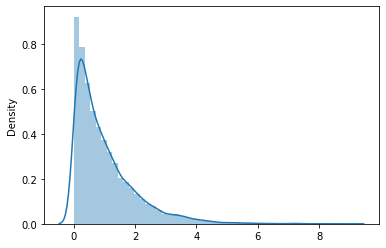

In [ ]:
data = np.random.exponential(size=10000)
sns.distplot(data)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


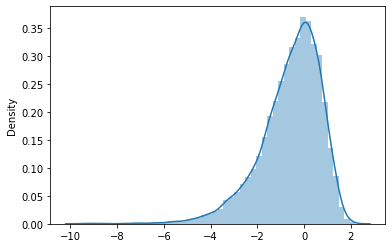

In [ ]:
sns.distplot(np.log(data))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


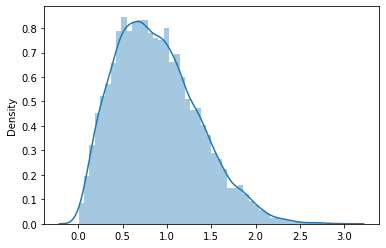

In [ ]:
sns.distplot(np.sqrt(data))

## Feature selection
- Too many feature columns can lead to two problems. the more feature we have,
  - the more likely we are to overfit to train/validation
  - the more time it will take to train model and optimize hyparameters

- Use feature selecition techniques to keep most informative features for our model

### Univariate Feature Selection
- the most simplest and fastest way are based on univariate statistical test,
  - 카이제곱 or ANOVA : F score
    - F-score measures the linear dependency between feature variables and target
    - this score might underestimate the relationship if they are under unlinear relationship 
  - mutual information score
    - this score is nonparametic and can capture nonlinear relationship


- from sklearn.feature_selection import SelectKBest, f_classif
  - feature_cols = ['a','b',...]
  - selector = SelectKBest(f_classif, k=5)
  - X_new = selector.fit_transform(df_train[feature_cols], df_train['target'])
  - X_new
    - we don't know which features selected
    - selector.inverse_transform(X_new)
  - selected_features = pd.DataFrame(selector.inverse_transform(X_new),  index=train.index, columns=feature_cols)
    - it will return df having origin index and columns(feature) but droped all variables from didn't selected features.
  - selected_columns = selected_features.columns[selected_features.var() != 0]

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
feature_cols = clicks.columns.drop(['click_time', 'attributed_time', 'is_attributed'])
train, valid, test = get_data_splits(clicks)

# Create the selector, keeping 40 features
selector = SelectKBest(f_classif, k=40)

# Use the selector to retrieve the best features
X_new = selector.fit_transform(train[feature_cols],train['is_attributed'])

# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(selector.inverse_transform(X_new),index=train.index,columns=feature_cols)

# Find the columns that were dropped
dropped_columns = selected_features.columns[selected_features.var() == 0]

# Check your answer
q_2.check()

### L1 regularization
- Univariate Feature Selection methods consider only one feature at a time when making a selection decision.
- L1 regulariation is helpful method to select informatic features and we could adjust parameter lambda of the method and find the parameter having best performance

  - from sklearn.linear_model import LogisticRegression
  - from sklearn.feature_selection import SelectFromModel
  - train, valid, _ = get_data_splits(df)
  - X, y = train[train.columns.drop("target")], train['target']
  - logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7).fit(X, y)
    - put the parameter C as 1
  - model = SelectFromModel(logistic, prefit=True)

  - X_new = model.transform(X)
  - X_new
    - similar to univariable featuer selection, we need to inverse_transfrom to get selected features col

  - selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X.index, columns=X.columns) 
  - selected_columns = selected_features.columns[selected_features.var() != 0]

In [ ]:
def select_features_l1(X, y):
    """Return selected features using logistic regression with an L1 penalty."""
    logistic = LogisticRegression(C=0.1,penalty='l1',random_state=7,solver='liblinear').fit(X,y)
    
    model = SelectFromModel(logistic, prefit=True)
    
    X_new = model.transform(X)
    
    selected_features = pd.DataFrame(model.inverse_transform(X_new),index=X.index,columns=X.columns)
    
    selected_columns = selected_features.columns[selected_features.var() != 0]

    return selected_columns

### More...
- we are using tree base model, so using other tree model to select features might make good performance.
  - RandomForestClassfier
  - ExtraTreesClassifer
  - AND SelectFromModel